# データセットの分割数の違いを感じる
- 学習データで学習 → テストデータでテスト → 誤り率を計算する
- 上記を繰り返して、誤り率の平均と分散を算出する
- CVの分割数 と ホールドアウト割合 を変えて算出する

# 実装のメモ

### アルゴリズムの流れ

1. データセットを取得

2. データセットを学習データと教師データに分割

3. 学習データを元にパラメータを学習

4. 教師データで誤り率を算出

5. 2〜4 を繰り返して、誤り率の標本データを取得し、平均分散を算出

6. 5 を CVの分割数 と ホールドアウトの割合 を変えて算出する


In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
%matplotlib inline

/Users/yohei.moriya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yohei.moriya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yohei.moriya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yohei.moriya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yohei.moriya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yoh

In [2]:
def get_data() -> pd.DataFrame:
    '''
    データセットを作成します
    '''
    origin_data = load_breast_cancer()
    df_origin = pd.DataFrame(origin_data.data, columns=origin_data.feature_names)
    df_origin['target'] = origin_data.target
    return df_origin

# test
df_origin = get_data()
df_origin.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [3]:
from abc import ABCMeta, abstractmethod


class Spliter(metaclass=ABCMeta):
    '''
    データの分割器です。
    '''
    def __init__(self, df, num):
        '''
        分割器を初期化します。
        '''
        self.df = df
        self.num = num

    @abstractmethod
    def run(self):
        '''
        データの分割を実行します。
        
        :return TrainDataSet, TestDataSet
        '''
        raise NotImplementedError()
        
    def to_str(self):
        return self.__class__.__name__ + '#' + str(self.num)


class FOSpliter(Spliter): 
    '''
    Fold Out法でデータを分割する分割器です。
    '''
    def __init__(self, df, num):
        '''
        :param df 分割したいデータ
        :param num データを分割するレート
        '''
        super().__init__(df, num)
    
    def run(self) -> pd.DataFrame:
        df_train = self.df.sample(frac=self.num, random_state=None)
        df_test = self.df.drop(df_train.index)
        yield df_train, df_test


class CVSpliter(Spliter):
    '''
    Cross Varidation法でデータを分割する分割器です。
    '''
    def __init__(self, df, num):
        '''
        :param df 分割したいデータ
        :param num データの分割する個数
        '''
        super().__init__(df, num)
        
    def run(self) -> pd.DataFrame:
        fold = KFold(n_splits=self.num, shuffle=True, random_state=None)
        for ids_train, ids_test in fold.split(self.df):
            df_train, df_test = self.df.iloc[ids_train], self.df.iloc[ids_test]
            yield df_train, df_test

#  test
df = get_data()
spliter_fo = FOSpliter(df=df, num=0.5)
spliter_cv = CVSpliter(df=df, num=4)
tasks = [spliter_fo, spliter_cv]
for task in tasks:
    print(task.to_str())
    for df_train, df_test in task.run():
        display(df_train.head())
        display(df_test.head())


FOSpliter#0.5


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
460,17.08,27.15,111.20,930.9,0.09898,0.11100,0.1007,0.06431,0.1793,0.06281,...,34.49,152.1,1648.0,0.1600,0.24440,0.2639,0.1555,0.3010,0.09060,0
174,10.66,15.15,67.49,349.6,0.08792,0.04302,0.0000,0.00000,0.1928,0.05975,...,19.20,73.2,408.3,0.1076,0.06791,0.0000,0.0000,0.2710,0.06164,1
250,20.94,23.56,138.90,1364.0,0.10070,0.16060,0.2712,0.13100,0.2205,0.05898,...,27.00,165.3,2010.0,0.1211,0.31720,0.6991,0.2105,0.3126,0.07849,0
83,19.10,26.29,129.10,1132.0,0.12150,0.17910,0.1937,0.14690,0.1634,0.07224,...,32.72,141.3,1298.0,0.1392,0.28170,0.2432,0.1841,0.2311,0.09203,0
86,14.48,21.46,94.25,648.2,0.09444,0.09947,0.1204,0.04938,0.2075,0.05636,...,29.25,108.4,808.9,0.1306,0.19760,0.3349,0.1225,0.3020,0.06846,0


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.1184,0.2776,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
3,11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.1003,0.1328,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0
5,12.45,15.70,82.57,477.1,0.1278,0.1700,0.1578,0.08089,0.2087,0.07613,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,0
12,19.17,24.80,132.40,1123.0,0.0974,0.2458,0.2065,0.11180,0.2397,0.07800,...,29.94,151.70,1332.0,0.1037,0.3903,0.3639,0.1767,0.3176,0.10230,0


CVSpliter#4


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
5,12.450,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,...,23.75,103.40,741.6,0.1791,0.5249,0.53550,0.17410,0.3985,0.12440,0
12,19.170,24.80,132.40,1123.0,0.09740,0.24580,0.20650,0.11180,0.2397,0.07800,...,29.94,151.70,1332.0,0.1037,0.3903,0.36390,0.17670,0.3176,0.10230,0
21,9.504,12.44,60.34,273.9,0.10240,0.06492,0.02956,0.02076,0.1815,0.06905,...,15.66,65.13,314.9,0.1324,0.1148,0.08867,0.06227,0.2450,0.07773,1
32,17.020,23.98,112.80,899.3,0.11970,0.14960,0.24170,0.12030,0.2248,0.06382,...,32.09,136.10,1344.0,0.1634,0.3559,0.55880,0.18470,0.3530,0.08482,0
33,19.270,26.47,127.90,1162.0,0.09401,0.17190,0.16570,0.07593,0.1853,0.06261,...,30.90,161.40,1813.0,0.1509,0.6590,0.60910,0.17850,0.3672,0.11230,0


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
8,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,...,30.73,106.2,739.3,0.1703,0.5401,0.5390,0.20600,0.4378,0.10720,0
10,16.02,23.24,102.70,797.8,0.08206,0.06669,0.03299,0.03323,0.1528,0.05697,...,33.88,123.8,1150.0,0.1181,0.1551,0.1459,0.09975,0.2948,0.08452,0
16,14.68,20.13,94.74,684.5,0.09867,0.07200,0.07395,0.05259,0.1586,0.05922,...,30.88,123.4,1138.0,0.1464,0.1871,0.2914,0.16090,0.3029,0.08216,0
22,15.34,14.26,102.50,704.4,0.10730,0.21350,0.20770,0.09756,0.2521,0.07032,...,19.08,125.1,980.9,0.1390,0.5954,0.6305,0.23930,0.4667,0.09946,0
23,21.16,23.04,137.20,1404.0,0.09428,0.10220,0.10970,0.08632,0.1769,0.05278,...,35.59,188.0,2615.0,0.1401,0.2600,0.3155,0.20090,0.2822,0.07526,0


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,0.2087,0.07613,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,0


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.26540,0.4601,0.11890,0
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.19320,0.3063,0.08368,0
14,13.73,22.61,93.60,578.3,0.11310,0.22930,0.21280,0.08025,0.2069,0.07682,...,32.01,108.80,697.7,0.1651,0.7725,0.6943,0.22080,0.3596,0.14310,0
19,13.54,14.36,87.46,566.3,0.09779,0.08129,0.06664,0.04781,0.1885,0.05766,...,19.26,99.70,711.2,0.1440,0.1773,0.2390,0.12880,0.2977,0.07259,1
20,13.08,15.71,85.63,520.0,0.10750,0.12700,0.04568,0.03110,0.1967,0.06811,...,20.49,96.09,630.5,0.1312,0.2776,0.1890,0.07283,0.3184,0.08183,1


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.26540,0.4601,0.11890,0
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,...,23.75,103.4,741.6,0.1791,0.5249,0.5355,0.17410,0.3985,0.12440,0
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,...,27.66,153.2,1606.0,0.1442,0.2576,0.3784,0.19320,0.3063,0.08368,0
8,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,...,30.73,106.2,739.3,0.1703,0.5401,0.5390,0.20600,0.4378,0.10720,0
10,16.02,23.24,102.70,797.8,0.08206,0.06669,0.03299,0.03323,0.1528,0.05697,...,33.88,123.8,1150.0,0.1181,0.1551,0.1459,0.09975,0.2948,0.08452,0


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0
7,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,0


In [4]:
def col_error(df_train: pd.DataFrame, df_test: pd.DataFrame):
    '''
    ロジスティック回帰を用いてテストデータの誤り率を計算します。
    '''
    df_train_x = df_train.drop('target', axis=1)
    df_train_y = df_train['target']
    lr = LogisticRegression()
    lr.fit(df_train_x, df_train_y)
    
    df_test_x = df_test.drop('target', axis=1)
    df_test_y = df_test['target']
    score = lr.score(df_test_x, df_test_y)
    
    return 1- score

# test
df = get_data()
print(col_error(df, df))

0.040421792618629215


In [5]:
class Aggregator():
    '''
    情報を貯蓄して解析する集積器です。
    内部でキーに対応したリストを保持しています。
    '''
    def __init__(self):
        self.values = {}

    def savings(self, key, value):
        '''
        値をキーに対応したリストに保存します。
        '''
        if key not in self.values:
            self.values[key] = []
        self.values[key].append(value)
        pass
    
    def total(self):
        '''
        貯蓄した値を集計します。
        '''
        dict_result = {}
        for key in self.values:
            info = {}
            info['mean'] = np.array(self.values[key]).mean()
            info['var'] = np.array(self.values[key]).var()
            dict_result[key] = info
        return pd.DataFrame.from_dict(dict_result).T
    
    def destory(self):
        '''
        貯蔵した値を破棄します。
        '''
        self.values = {}

memory = Aggregator()
memory.savings('key1', 1)
memory.savings('key1', 2)
memory.savings('key2', 3)
print(memory.values)

{'key1': [1, 2], 'key2': [3]}


In [6]:
class drawthy:
    """
    グラフを描画するクラスです。
    """
    def __init__(self, x, y):
        self.x = x
        self.y = y
        

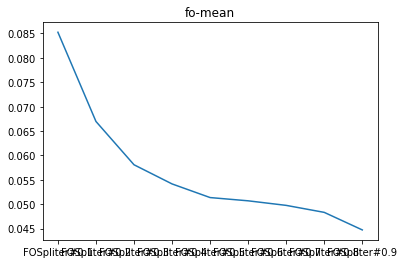

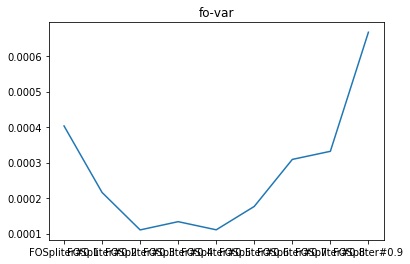

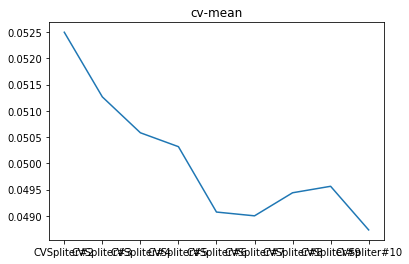

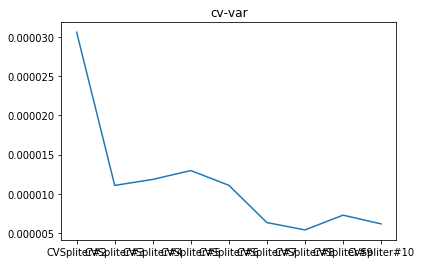

In [24]:
def run_task(memory, task):
    error = []
    for df_train, df_test in task.run():
        error.append(col_error(df_train, df_test))
    memory.savings(task.to_str(), np.mean(error))
    return memory

def run_tasks(memory, tasks):
    for task in tasks:
        memory = run_task(memory, task)
    return memory

def main():
    memory = Aggregator()
    for i in range(100):
        df_origin = get_data()
        tasks_fo = [FOSpliter(df=df_origin, num=round(num*0.1, 1)) for num in range(1, 10)]
        tasks_cv = [CVSpliter(df=df_origin, num=(num)) for num in range(2, 11)]
        tasks = tasks_fo + tasks_cv
        memory = run_tasks(memory, tasks)
    df_total = memory.total()
    df_total_fo = df_total[df_total.index.str.contains('FO')]
    df_total_cv = df_total[df_total.index.str.contains('CV')]
#     display(df_total_fo)
#     display(df_total_cv)
    
    # plot
    plt.plot(df_total_fo.index, df_total_fo['mean'])
    plt.title('fo-mean')
    plt.show()
    plt.plot(df_total_fo.index, df_total_fo['var'])
    plt.title('fo-var')
    plt.show()
    
    plt.plot(df_total_cv.index, df_total_cv['mean'])
    plt.title('cv-mean')
    plt.show()
    plt.plot(df_total_cv.index, df_total_cv['var'])
    plt.title('cv-var')
    plt.show()

main()